In [6]:
 # Created Jan 9, 2022
# Updated Jan 9, 2022
import sys; sys.path.insert(0, '../../') ## make sure path to root of project directory
from wu_barcodes.config import *

import matplotlib as mpl
# mpl formatting
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl_configs)
import methods.ax_methods as ax_methods
import numpy as np; rnd = np.random.default_rng()
import scipy.stats

import pickle

if True:
    with open(f'{data_dir}2/bac_lineage_positions.pkl', 'rb') as f:
        bac_lineage_positions = pickle.load(f)

    with open(f'{data_dir}2/bac_row_ids.pkl', 'rb') as f:
        bac_row_ids = pickle.load(f)

    with open(f'{data_dir}2/bac_read_arrays.pkl', 'rb') as f:
        bac_read_arrays = pickle.load(f)

    with open(f'{data_dir}2/bac_input_arrays.pkl', 'rb') as f:
        bac_input_arrays = pickle.load(f)

    with open(f'{data_dir}2/gene_meta_dict.pkl', 'rb') as f:
        bac_gene_meta_dict = pickle.load(f)

    with open(f'{data_dir}2/lineage_gene_map.pkl', 'rb') as f:
        bac_lineage_gene_map = pickle.load(f)

    with open(f'{data_dir}2/nonwu_indices.pkl', 'rb') as f:
        bac_nonwu_indices = pickle.load(f)

import methods.sim_barcodes as sim
import methods.filter_lineages as fl

In [7]:
import scipy.ndimage.filters as ndif
def running_mean_uniform_filter1d(x, N):
    return ndif.uniform_filter1d(x, N, mode='reflect', origin=0)

def calc_coarse_grained_lfc_array(freqs0, D0, freqs1, D1, dt, coarse_grain=100):
    cg_freqs0 = running_mean_uniform_filter1d(freqs0, coarse_grain)
    cg_freqs1 = running_mean_uniform_filter1d(freqs1, coarse_grain)

    cg_f0, cg_f1 = fl.maxmin_freqs(cg_freqs0, D0, cg_freqs1, D1)

    with np.errstate(divide='ignore'):
        return np.log( cg_f1/cg_f0 ) / dt

##sims
def sim_population_frequencies(init_freqs, fitnesses, gens=4, N=1e12, D_lst=[3*10**5]*5, num_populations=5):
    population_frequencies = np.zeros((num_populations, len(init_freqs)))
    population_reads = np.zeros((num_populations, len(init_freqs)))
    for i in range(num_populations):
        pop = sim.Population(init_freqs, np.copy(fitnesses), N)
        pop.simulate(gens)

        pop.N = D_lst[i]
        pop.xs[:] = 0
        pop.simulate(1) # first poisson samplng ~ DNA extraction

        reads = pop.sample(pop.N)
        population_reads[i] = reads
        population_frequencies[i] = reads/reads.sum()
    return population_frequencies, population_reads

def generate_empirical_ordered_fitnesses(bac, mice, t=4):
    nonWu = fl.bac_nonwu_indices[bac]
    read_arrays = fl.bac_read_arrays[bac][:, nonWu]
    row_ids = fl.bac_row_ids[bac]
    day0_freqs = read_arrays[0] / read_arrays[0].sum()

    mice_reads = read_arrays[ [row_ids[(mouse, t)] for mouse in mice ] ]
    avg_freqs = mice_reads.sum(axis=0) / mice_reads.sum()
    where_large = day0_freqs > 1e-7

    f0, f1 = fl.maxmin_freqs(day0_freqs[where_large], read_arrays[0].sum(), avg_freqs[where_large], mice_reads.sum())

    empirical_fitnesses = fl.calc_lfc_array(f0, f1, t)
    sorted_indices = np.argsort(empirical_fitnesses)[::-1]
    sorted_fitnesses = empirical_fitnesses[sorted_indices]
    sorted_indices = np.arange(day0_freqs.shape[-1])[where_large][sorted_indices]

    return sorted_fitnesses, sorted_indices


In [8]:
import sklearn.isotonic as isotonic

for bac in BACTERIA:
    print(fl.bac_input_arrays[bac][:][:, fl.bac_nonwu_indices[bac]].sum() * 1e-6)

30.588131999999998
36.125133999999996
28.523618
18.294646999999998


/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:278: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1[valid]/freqs0[valid] ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:278: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1[valid]/freqs0[valid] ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:278: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1[valid]/freqs0[valid] ) / dt


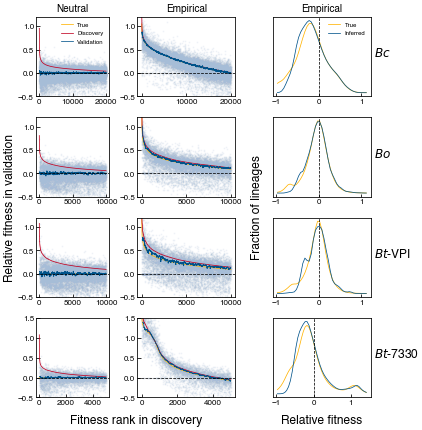

In [21]:
def double_poisson(freqs, D0, D1):
    amplicons0 = rnd.poisson( freqs * D0 )
    reads0 = rnd.poisson( amplicons0 / amplicons0.sum() * D1)
    freqs0 = reads0 / reads0.sum()
    return reads0, freqs0

min_reads = 5
cutoff = 10**-6.5

fig = plt.figure(figsize=(6,7))
outer = mpl.gridspec.GridSpec(nrows=7, ncols=5, height_ratios=[1,0.03, 1, 0.03, 1, 0.03, 1],
                              width_ratios=[0.75,0.05,1,0.15,1], figure=fig)

rank_ax = fig.add_subplot(outer[:, :3])
rank_ax.set_xlabel('Fitness rank in discovery', fontsize=12, labelpad=10)
rank_ax.set_ylabel('Relative fitness in validation', fontsize=12, labelpad=10)
ax_methods.turn_off_ax(rank_ax)

for b, bac in enumerate(['BWH2', 'Bovatus', 'BtVPI', 'Bt7330']):
    row_ax = fig.add_subplot(outer[2*b, :])
    ax_methods.turn_off_ax(row_ax)
    # row_ax.set_ylabel(BAC_FORMAL_NAMES[bac], labelpad=15, fontsize=10)
    row_ax.text(1.01, 0.5, BAC_FORMAL_NAMES[bac],
                      transform=row_ax.transAxes,
                      fontsize=12, weight='bold')

for i, col_title in enumerate(['Neutral', 'Empirical', 'Empirical']):
    col_ax = fig.add_subplot(outer[:, 2*i])
    col_ax.set_title(col_title)

    if i == 2:
        col_ax.set_ylabel('Fraction of lineages', fontsize=12)
        col_ax.set_xlabel('Relative fitness', fontsize=12, labelpad=10)
    ax_methods.turn_off_ax(col_ax)


discovery, validation = [6, 7, 8, 9, 10], [1, 2, 3, 5]
# discovery, validation = [6], [1]
for b, (bac, R) in enumerate(zip(BACTERIA, [20000, 10000, 10000, 5000])):
    row_ids = fl.bac_row_ids[bac]
    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]
    input_array = fl.bac_input_arrays[bac][:, notWu]


    emp_fitnesses, emp_sorted_indices = generate_empirical_ordered_fitnesses(bac, [1, 2, 3, 5, 6, 7, 8, 9, 10], 4)
    emp_fitnesses[ emp_fitnesses < -1] = -1
    emp_fitnesses[ emp_fitnesses > 1.5] = 1.5

    D = read_array[ [row_ids[(mouse,4)] for mouse in discovery+validation]].sum(axis=1)
    num_mice = len(discovery+validation )

    d0_reads = read_array[0][emp_sorted_indices]
    # discovery_reads0 = input_array[0::2][:, emp_sorted_indices].sum(axis=0)
    # # discovery_reads0 -= input_array[18][emp_sorted_indices]
    # discovery_freqs0 = discovery_reads0 / discovery_reads0.sum()
    # validation_reads0 = input_array[1::2][:, emp_sorted_indices].sum(axis=0)
    # validation_freqs0 = validation_reads0 / validation_reads0.sum()

    d0_reads = read_array[0][emp_sorted_indices]
    init_freqs = d0_reads / d0_reads.sum()
    neut_fitnesses = np.zeros( init_freqs.shape[-1] )

    input_depths = input_array.sum(axis=1)
    sim_input_array = np.zeros((len(input_depths), d0_reads.shape[-1]))
    for i, depth in enumerate(input_depths):
        sim_input_reads, _ = double_poisson(init_freqs, depth, depth)
        sim_input_array[i] = sim_input_reads

    discovery_reads0 = sim_input_array[0::2].sum(axis=0)
    discovery_freqs0 = discovery_reads0 / discovery_reads0.sum()
    validation_reads0 = sim_input_array[1::2].sum(axis=0)
    validation_freqs0 = validation_reads0 / validation_reads0.sum()



    for n, (sim_fitnesses, title) in enumerate([(neut_fitnesses, f'{bac} neutral'), (emp_fitnesses/10, f'{bac} empirical')]):
        # ax = fig.add_subplot( outer[4*(b//2)+2*n, 2*(b%2)])
        ax = fig.add_subplot( outer[2*b, 2*n])

        sim_init_freqs = np.copy(init_freqs)
        pop_freqs, pop_reads = sim_population_frequencies(sim_init_freqs, sim_fitnesses, gens=40, N=10**8, D_lst=D, num_populations=num_mice)

        num_discovery = len(discovery)
        discovery_reads1 = pop_reads[:num_discovery].sum(axis=0)
        discovery_freqs1 = discovery_reads1 / discovery_reads1.sum()
        validation_reads1 = pop_reads[num_discovery:].sum(axis=0)
        validation_freqs1 = validation_reads1 / validation_reads1.sum()

        filter_freqs = np.max([discovery_freqs1, discovery_freqs0], axis=0)
        # filter_bool = fl.filter_pairs((discovery_reads0, discovery_reads1), (validation_reads0, validation_reads1), threshold=filter_freqs, min_reads=min_reads, union=False)
        filter_bool = fl.filter_lineages(validation_reads0, validation_reads1, min_reads=5, threshold=filter_freqs)
        filtered_lineages = (sim_init_freqs > cutoff) * filter_bool

        d_f0, d_f1 = fl.maxmin_freqs(discovery_freqs0, discovery_reads0.sum(),
                                  discovery_freqs1, discovery_reads1.sum())

        v_f0, v_f1 = fl.maxmin_freqs(validation_freqs0, validation_reads0.sum(),
                                  validation_freqs1, validation_reads1.sum())

        d_lfcs = fl.calc_lfc_array(d_f0, d_f1, 4, valid=filtered_lineages)
        v_lfcs = fl.calc_lfc_array(v_f0, v_f1, 4, valid=filtered_lineages)

        sorted_indices = np.argsort(d_lfcs)[::-1]
        sorted_d_lfcs = d_lfcs[sorted_indices]
        sorted_v_lfcs = v_lfcs[sorted_indices]

        cg_validate_lfcs = calc_coarse_grained_lfc_array(validation_freqs0[filtered_lineages][sorted_indices], validation_reads0.sum(),
                                                             validation_freqs1[filtered_lineages][sorted_indices], validation_reads1.sum(),
                                                             4, coarse_grain=100)

        theory_int_xbar = np.log( (sim_init_freqs * np.exp(sim_fitnesses*40)).sum() )
        theory_fitnesses = sorted(sim_fitnesses[filtered_lineages]*10 - theory_int_xbar/4, reverse=True)

        ax.scatter(np.arange(sorted_v_lfcs.shape[-1])[:R], sorted_v_lfcs[:R], rasterized=True, s=1, color=KELLY_COLORS[3], alpha=0.1)
        ax.plot(theory_fitnesses[:R], color=KELLY_COLORS[0], label='True')
        ax.plot(sorted_d_lfcs[:R], color=KELLY_COLORS[4], label='Discovery')
        l  = min([R, len(cg_validate_lfcs)])

        ax.plot(np.arange(50, l), cg_validate_lfcs[50:l], color=KELLY_COLORS[9], label='Validation')

        ax.axhline(0, color='black', linestyle='dashed')
        if bac == 'BWH2' and n==0:
            ax.legend(frameon=False)
        if bac == 'Bt7330':
            ax.set_ylim(-0.5, 1.5)
        else:
            ax.set_ylim(-0.5, 1.2)
        ax.tick_params(axis='both', labelsize=8)



    fitnesses = cg_validate_lfcs[50:-50][::-1]

    dx = 0.05
    if bac == 'Bt7330':
        x = np.arange(-1.0, 1.5, dx)
    else:
        x = np.arange(-1.0, 1.2, dx )
    x_avg = (x[1:]+x[:-1])/2
    #
    # # iso_reg = isotonic.IsotonicRegression().fit(fitnesses, ranks[::-1])
    # # cdf = iso_reg.predict(x) # # # print(iso_y[10:])
    # # dfe = (cdf[1:]-cdf[:-1]) / dx
    # # # ax.plot(x_avg, dfe, color=KELLY_COLORS[b], linestyle='dotted')
    #
    # iso_reg = isotonic.IsotonicRegression().fit(ranks, fitnesses)
    # iso_y = iso_reg.predict(ranks) # # # print(iso_y[10:])
    #
    # g = calculate_monotonic_interpolation_function(ranks, fitnesses)
    # iso_y = g.predict(ranks) # # # print(iso_y[10:])
    #
    # # iso_y += rnd.normal(scale=1e-5, size=iso_y.shape[0])
    # # sort = np.argsort(iso_y)
    # # c3_spline = scipy.interpolate.PchipInterpolator(iso_y[sort], ranks[sort])
    # # cdf = c3_spline(x)
    # # deriv = c3_spline.derivative(1)
    # # dfe = (cdf[1:]-cdf[:-1]) / dx
    # # # ax.plot(x_avg, dfe, color='black', linestyle='dotted')
    # # # ax.plot(x_avg, deriv(x_avg), color=KELLY_COLORS[b], linestyle='dotted')
    #
    kernel = scipy.stats.gaussian_kde(fitnesses, bw_method=0.2)
    emp_kernel = scipy.stats.gaussian_kde(emp_fitnesses[filtered_lineages], bw_method=0.2)
    ax = fig.add_subplot(outer[2*b, -1])

    density, _ = np.histogram(emp_fitnesses[filtered_lineages], bins=x, density=True)
    ax.plot(x_avg, emp_kernel(x_avg), color=KELLY_COLORS[0])
    ax.plot(x_avg, kernel(x_avg), color=KELLY_COLORS[9])
    ax.axvline(0, color='black', linestyle='dashed')
    ax.tick_params(axis='both', labelsize=8)
    ax.set_yticks([])
    if bac == 'BWH2':
        ax.legend(['True', 'Inferred'], frameon=False)


fig.savefig(f'{biorxiv}/SI_simulated_rank_order_curves.pdf')
